# ***Movie Recommendation System***

In [7]:
import pandas as pd

# Load dataset directly from a URL (MovieLens 100k Dataset)
movies_url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/u.item'
ratings_url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/u.data'

# Define the column names for both datasets
movie_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown',
              'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
              'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
              'War', 'Western']

# Loading the movies data
movies = pd.read_csv(movies_url, sep='|', names=movie_cols, encoding='latin-1')

# Loading the ratings data
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_url, sep='\t', names=ratings_cols)

# Preview the datasets
print(movies.head())
print(ratings.head())


   movie_id        movie_title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1         1  ...        0          0       0        0   


In [10]:
# Merging both datasets (movies + ratings)
movie_data = pd.merge(ratings, movies[['movie_id', 'movie_title']], on='movie_id')

# Dropping unnecessary columns
movie_data = movie_data.drop(columns=['timestamp'])

# Preview the merged dataset
print(movie_data.head())

# Create a pivot table where rows represent users and columns represent movie ratings
user_movie_matrix = movie_data.pivot_table(index='user_id', columns='movie_title', values='rating')

# Showing a sample of the user-item matrix
print(user_movie_matrix.head())



   user_id  movie_id  rating   movie_title
0      196       242       3  Kolya (1996)
1       63       242       3  Kolya (1996)
2      226       242       5  Kolya (1996)
3      154       242       3  Kolya (1996)
4      306       242       5  Kolya (1996)
movie_title  'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                       
1                                  NaN           NaN                    2.0   
2                                  NaN           NaN                    NaN   
3                                  NaN           NaN                    NaN   
4                                  NaN           NaN                    NaN   
5                                  NaN           NaN                    2.0   

movie_title  12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user_id                                                                     
1                            5.0  

<ipython-input-12-c72814b289d2>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_movies['average_rating'], y=top_10_movies.index, palette='coolwarm')


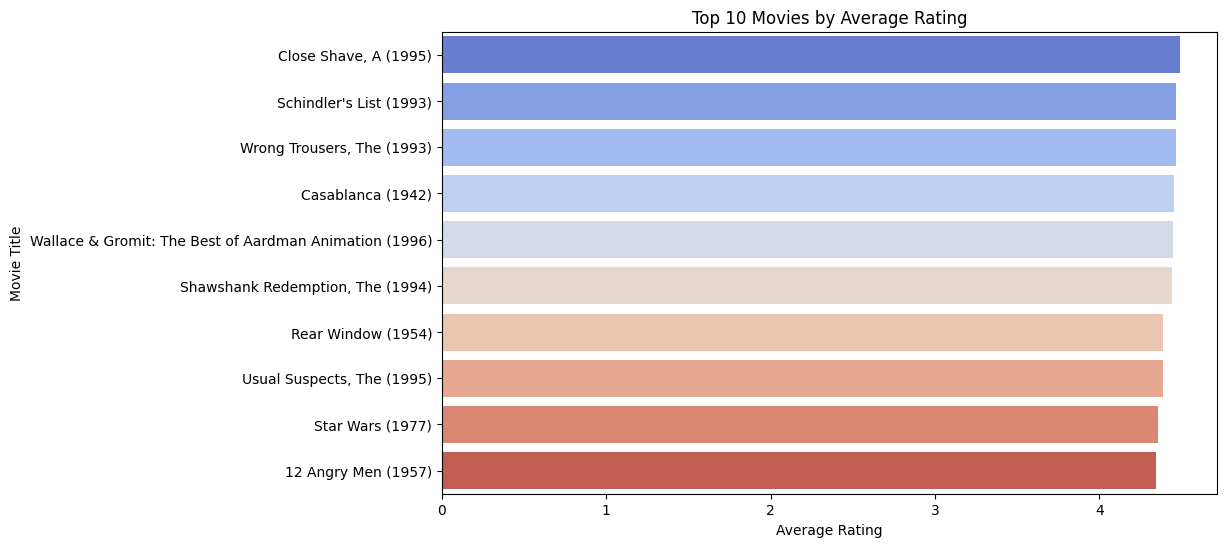

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping the movie data by movie title
movie_ratings = movie_data.groupby('movie_title').agg({'rating': ['mean', 'count']})
movie_ratings.columns = ['average_rating', 'num_ratings']

# Filtering movies with at least 50 ratings for better accuracy
popular_movies = movie_ratings[movie_ratings['num_ratings'] >= 50]

# Plotting a bar graph for the top 10 most popular movies by average rating
top_10_movies = popular_movies.sort_values('average_rating', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_movies['average_rating'], y=top_10_movies.index, palette='coolwarm')
plt.title('Top 10 Movies by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


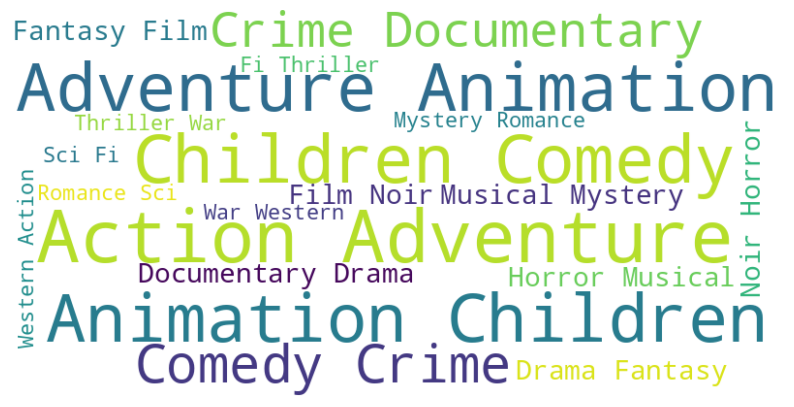

In [13]:
from wordcloud import WordCloud

# Joining all genres from the movies dataset to create a genre word cloud
genres = movies[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                 'War', 'Western']]

genre_list = genres.columns[genres.any()].tolist()

# Create a string of genres for word cloud
genre_string = " ".join(genre_list * 100)

# Create the word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(genre_string)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [18]:
# Function to recommend movies based on correlation
def recommend_movies(movie_name, min_ratings=50):
    with warnings.catch_warnings():  # Suppress warnings in this block
        warnings.simplefilter("ignore")
        movie_ratings = user_movie_matrix[movie_name]
        similar_movies = user_movie_matrix.corrwith(movie_ratings)
        corr_movies = pd.DataFrame(similar_movies, columns=['correlation'])
        movie_ratings_count = movie_data.groupby('movie_title').size()
        corr_movies = corr_movies.join(movie_ratings_count.rename('num_ratings'))
        recommendations = corr_movies[corr_movies['num_ratings'] >= min_ratings].sort_values('correlation', ascending=False)
        return recommendations.head(10)


In [22]:
# Function to display the visuals (Bar plot and Word Cloud)
def display_visuals(recommended_movies):
    with warnings.catch_warnings():  # Suppress warnings related to visuals
        warnings.simplefilter("ignore")

        # Word Cloud
        genres = movies[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                         'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                         'War', 'Western']]
        genre_list = genres.columns[genres.any()].tolist()

        wordcloud = WordCloud(background_color='black', width=300, height=350, colormap='coolwarm').generate(" ".join(genre_list))
        plt.figure(figsize=(4, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout()
        wordcloud_output.clear_output()
        with wordcloud_output:
            plt.show()

        # Bar Plot (This will go in the second row)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=recommended_movies['correlation'], y=recommended_movies.index, palette='coolwarm')
    plt.title('Recommended Movies by Correlation', fontsize=16, fontweight='bold')
    plt.xlabel('Correlation', fontsize=14 )
    plt.ylabel('Movie Title', fontsize=14 )
    plt.xticks(fontsize=12 )
    plt.yticks(fontsize=12)
    plt.gca().set_facecolor('#2c2c2c')
    plt.tight_layout()
    barplot_output.clear_output()
    with barplot_output:
        plt.show()

In [24]:
import pandas as pd
import requests
import warnings  # Importing warnings to suppress them
from IPython.display import Image, display, HTML, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import ipywidgets as widgets
from wordcloud import WordCloud


# Path to your local fallback image
fallback_image_path = '/content/Designer (3).png'  # Replace with the actual path to your image

# Function to fetch movie poster from OMDb API
def get_movie_poster(movie_name):
    OMDB_API_KEY = 'your_api_key_here'  # Replace with your OMDb API key
    url = f"http://www.omdbapi.com/?t={movie_name.replace(' ', '+')}&apikey={OMDB_API_KEY}"

    response = requests.get(url)
    data = response.json()

    if data['Response'] == 'True' and 'Poster' in data and data['Poster'] != 'N/A':
        poster_url = data['Poster']
        display(Image(poster_url, width=250, height=350))
    else:
        display(Image(fallback_image_path, width=250, height=350))




# Function to handle button click event
def on_button_clicked(b):
    with output:
        clear_output()  # Clear previous output

        try:
            selected_movie = movie_selector.value
            recommended_movies = recommend_movies(selected_movie, num_recommendations_slider.value)

            # Determine font size based on number of recommendations
            num_movies = len(recommended_movies)
            base_font_size = 18  # Starting font size
            adjusted_font_size = max(12, base_font_size - (num_movies - 5))  # Decrease font size for more movies

            # Create HTML content with dynamically adjusted font size
            recommendations_html = f"<h3 style='color: white;'>Recommended Movies for '{selected_movie}'</h3><ul style='font-size: {adjusted_font_size}px;'>"
            for movie_title in recommended_movies.index:
                recommendations_html += f"<li>{movie_title}</li>"
            recommendations_html += "</ul>"

            # Display recommendations and poster in first row
            recommendations_output.clear_output()
            with recommendations_output:
                display(HTML(recommendations_html))

            display_visuals(recommended_movies)
            poster_output.clear_output()
            with poster_output:
                get_movie_poster(selected_movie)

        except Exception as e:
            display(HTML(f"<p style='color: red;'>An error occurred: {e}</p>"))


# Movie selector dropdown
movie_selector = widgets.Dropdown(
    options=movie_data['movie_title'].unique(),
    description='Movie:',
    layout=widgets.Layout(width='100%'),
    style={'description_width': 'initial'}
)

# Slider for number of recommendations
num_recommendations_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Top N:',
    layout=widgets.Layout(width='100%'),
    style={'description_width': 'initial'}
)

# Button for generating recommendations
recommend_button = widgets.Button(
    description="Get Recommendations",
    button_style='success',
    layout=widgets.Layout(width='100%', margin='10px 0 10px 0'),
    style={'font_weight': 'bold'}
)

# Output areas
output = widgets.Output()
poster_output = widgets.Output(layout=widgets.Layout(height='auto', width='auto'))
recommendations_output = widgets.Output(layout=widgets.Layout(height='auto', width='300px'))
wordcloud_output = widgets.Output(layout=widgets.Layout(height='auto', width='300px'))
barplot_output = widgets.Output()

# Bind the button click event to the function
recommend_button.on_click(on_button_clicked)

# UI Header and Signature (HTML styling for a better look)
header = widgets.HTML(
    """
    <h1 style='
        color: #FFFFFF;
        font-family: "Trebuchet MS", Arial, sans-serif;
        text-align: center;
        font-size: 3em;
        background: linear-gradient(90deg, rgba(229,9,20,1) 0%, rgba(144,12,63,1) 50%, rgba(0,212,255,1) 100%);
        padding: 10px;
        border-radius: 10px;
        box-shadow: 0px 0px 15px rgba(229,9,20,0.8);
        '>🎥 Movie Recommendation Dashboard 🎥</h1>
    """
)
description = widgets.HTML(
    """
    <h2 style='
        text-align: center;
        font-family: "Verdana", sans-serif;
        color: #000000;
        font-size: 1.2em;
        padding: 5px;'>Select a movie and get personalized recommendations based on similar movies.</h2>
    """
)
signature = widgets.HTML(
    """
    <p style='
        color: #000000;
        font-family: Arial;
        text-align: center;
        margin-top: 20px;
        font-size: 1.6em;
        border-top: 1px solid #555;
        padding-top: 10px;
        background: linear-gradient(90deg, rgba(0,212,255,1) 0%, rgba(144,12,63,1) 100%);
        '>© 2024 Created by AI Innovators</p>
    """
)

# Layout for the first row (Word Cloud, Poster, Recommendations)
first_row = widgets.HBox([
    wordcloud_output,  # Word cloud on the left
    poster_output,     # Poster in the middle
    recommendations_output  # Recommendations on the right
], layout=widgets.Layout(justify_content='space-around', margin='5px', align_items='stretch'))

# Full UI layout with glowing border
ui = widgets.VBox([
    header,
    description,
    movie_selector,
    num_recommendations_slider,
    recommend_button,
    first_row,        # First row with Word Cloud, Poster, and Recommendations
    barplot_output,
    signature# Second row with Bar Plot (Full width)
], layout=widgets.Layout(
    width='Auto',
    margin='0 auto',
    background_color='#000000',
    padding='20px',
    border_radius='20px',
    box_shadow='0px 0px 20px 5px rgba(255, 99, 71, 0.7), 0px 0px 20px 5px rgba(0, 255, 255, 0.5)',  # Glowing border
    border='2px solid #E50914'
))

# Display the full UI
display(ui)


# **HAPPY COADING**